# ⚛️ H₃⁺ Noisy VQE — UCC-S vs UCC-D vs UCCSD

This notebook benchmarks **noisy VQE** for **H₃⁺** using three chemistry-inspired ansatzes:
- **UCC-S** (singles)
- **UCC-D** (doubles)
- **UCCSD** (singles + doubles)

It is a **pure client** of the VQE package:

```python
from vqe.core import run_vqe
```

The package handles Hamiltonian construction, ansatz construction, device/noise setup,
caching, and optimisation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from common.plotting import save_plot, build_filename
from common.molecules import get_molecule_config
from common.molecule_viz import plot_molecule
from vqe.core import run_vqe

In [2]:
seed = 0

molecule = "H3+"

# Noise parameters (per qubit)
depolarizing_prob = 0.05
amplitude_damping_prob = 0.05

# Ansatz comparison
ansatzes = ["UCC-S", "UCC-D", "UCCSD"]

# Optimisation settings
optimizer_name = "Adam"
steps = 50
stepsize = 0.2

## 🧬 Geometry (registry) visualization

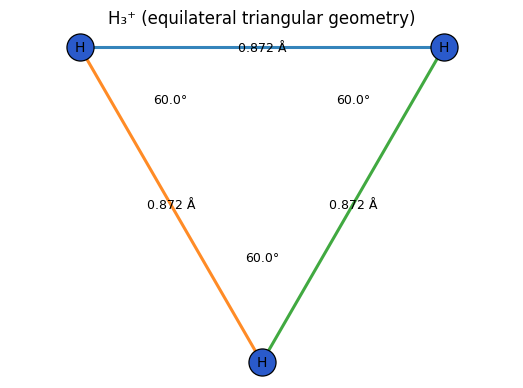

In [3]:
mol = get_molecule_config(molecule)

plot_molecule(
    mol["symbols"],
    mol["coordinates"],
    title="H₃⁺ (equilateral triangular geometry)",
    bonds=[(0, 1), (1, 2), (2, 0)],
    angles=[(0, 1, 2), (1, 2, 0), (2, 0, 1)],
    show_bond_lengths=True,
    show_atom_indices=False,
)
plt.show()

## 🚀 Run noisy VQE for each ansatz

In [4]:
results = {}

for ans in ansatzes:
    print(f"\n▶ Running NOISY VQE: molecule={molecule}, ansatz={ans}")
    res = run_vqe(
        molecule=molecule,
        ansatz_name=ans,
        optimizer_name=optimizer_name,
        steps=int(steps),
        stepsize=float(stepsize),
        noisy=True,
        depolarizing_prob=float(depolarizing_prob),
        amplitude_damping_prob=float(amplitude_damping_prob),
        mapping="jordan_wigner",
        seed=int(seed),
        plot=False,
        force=False,
    )
    results[ans] = res

num_qubits = int(next(iter(results.values()))["num_qubits"])
print(f"\nSystem qubits: {num_qubits}")


▶ Running NOISY VQE: molecule=H3+, ansatz=UCC-S
Step 01/50: E = -1.091544 Ha
Step 02/50: E = -1.091294 Ha
Step 03/50: E = -1.091631 Ha
Step 04/50: E = -1.093193 Ha
Step 05/50: E = -1.091558 Ha
Step 06/50: E = -1.093174 Ha
Step 07/50: E = -1.095972 Ha
Step 08/50: E = -1.096225 Ha
Step 09/50: E = -1.094565 Ha
Step 10/50: E = -1.094075 Ha
Step 11/50: E = -1.095442 Ha
Step 12/50: E = -1.096788 Ha
Step 13/50: E = -1.096840 Ha
Step 14/50: E = -1.096201 Ha
Step 15/50: E = -1.095936 Ha
Step 16/50: E = -1.096272 Ha
Step 17/50: E = -1.096748 Ha
Step 18/50: E = -1.096976 Ha
Step 19/50: E = -1.097023 Ha
Step 20/50: E = -1.097019 Ha
Step 21/50: E = -1.096963 Ha
Step 22/50: E = -1.096908 Ha
Step 23/50: E = -1.097018 Ha
Step 24/50: E = -1.097297 Ha
Step 25/50: E = -1.097484 Ha
Step 26/50: E = -1.097388 Ha
Step 27/50: E = -1.097185 Ha
Step 28/50: E = -1.097194 Ha
Step 29/50: E = -1.097427 Ha
Step 30/50: E = -1.097599 Ha
Step 31/50: E = -1.097546 Ha
Step 32/50: E = -1.097418 Ha
Step 33/50: E = -1.0974

## 📉 Convergence comparison

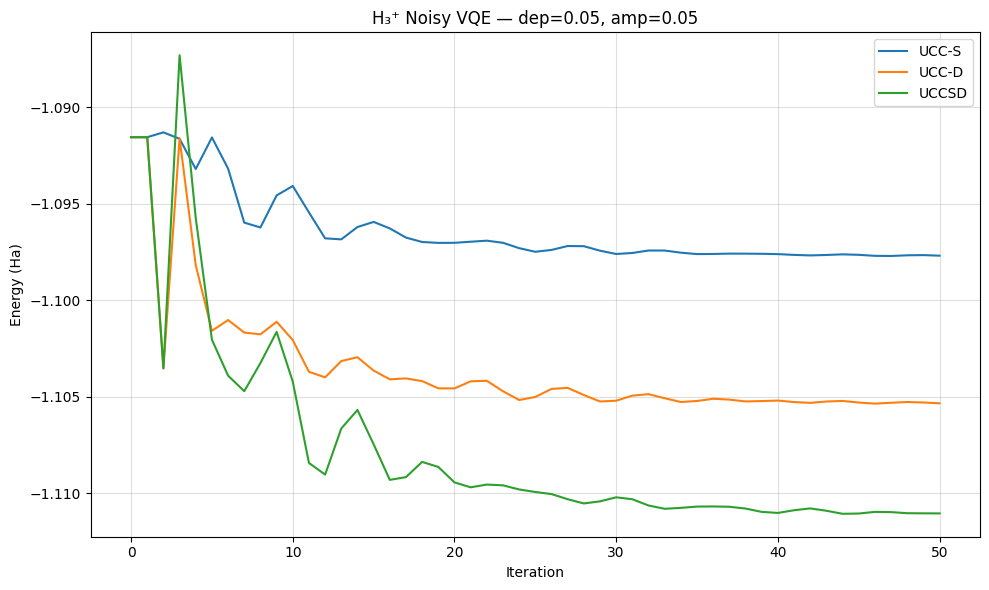

📁 Saved plot → /workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/ansatz_conv_Adam_dep05_amp05_s0.png


'/workspaces/Variational_Quantum_Eigensolver/images/vqe/H3plus/ansatz_conv_Adam_dep05_amp05_s0.png'

In [5]:
plt.figure(figsize=(10, 6))
for ans in ansatzes:
    plt.plot(results[ans]["energies"], label=ans)

plt.title(f"H₃⁺ Noisy VQE — dep={depolarizing_prob}, amp={amplitude_damping_prob}")
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()

fname = build_filename(
    topic="ansatz_conv",
    optimizer=optimizer_name,
    dep=float(depolarizing_prob),
    amp=float(amplitude_damping_prob),
    seed=int(seed),
    multi_seed=False,
)
save_plot(fname, kind="vqe", molecule=molecule, show=True)

## 📊 Final energies summary

In [6]:
print("\nFinal energies (noisy runs):")
for ans in ansatzes:
    print(f"  {ans:6s} → E = {float(results[ans]['energy']):.8f} Ha")


Final energies (noisy runs):
  UCC-S  → E = -1.09768626 Ha
  UCC-D  → E = -1.10533721 Ha
  UCCSD  → E = -1.11104252 Ha


## 🔬 Approximate population distributions (diag of final state)

`run_vqe` stores the final state in `final_state_real/imag`.
- Noiseless runs: statevector → we report |ψᵢ|²
- Noisy runs: density matrix → we report diag(ρ)

In [7]:
def approx_population(record: dict, *, threshold: float = 1e-2) -> str:
    r = np.array(record["final_state_real"], dtype=float)
    i = np.array(record["final_state_imag"], dtype=float)
    state = r + 1j * i

    if state.ndim == 1:
        diag = np.abs(state) ** 2
    elif state.ndim == 2:
        diag = np.clip(np.real(np.diag(state)), 0.0, None)
    else:
        raise ValueError(f"Unexpected state shape: {state.shape}")

    n = int(record.get("num_qubits", 0)) or int(np.round(np.log2(len(diag))))

    terms = [
        f"({float(p):.4f})|{idx:0{n}b}⟩"
        for idx, p in enumerate(diag)
        if float(p) > float(threshold)
    ]
    return " + ".join(terms) if terms else "(all populations below threshold)"

for ans in ansatzes:
    print("\n" + "-" * 70)
    print(f"Approximate population distribution for {ans}:")
    print(approx_population(results[ans], threshold=1e-2))


----------------------------------------------------------------------
Approximate population distribution for UCC-S:
(0.0620)|011000⟩ + (0.0625)|101000⟩ + (0.0620)|110000⟩ + (0.6969)|111000⟩ + (0.0230)|111001⟩ + (0.0228)|111010⟩ + (0.0228)|111100⟩

----------------------------------------------------------------------
Approximate population distribution for UCC-D:
(0.0615)|011000⟩ + (0.0615)|101000⟩ + (0.0615)|110000⟩ + (0.6919)|111000⟩ + (0.0226)|111001⟩ + (0.0226)|111010⟩ + (0.0226)|111100⟩

----------------------------------------------------------------------
Approximate population distribution for UCCSD:
(0.0592)|011000⟩ + (0.0597)|101000⟩ + (0.0612)|110000⟩ + (0.0240)|110010⟩ + (0.6659)|111000⟩ + (0.0220)|111001⟩ + (0.0225)|111010⟩ + (0.0218)|111100⟩
